### Training and Productionizing
- In this notebook, we are going to do an official REST API example where we are going to retrieve a fashion dataset that is open sourced by Zalando and then train a keras model.
- Then, we are going to save this model locally.
- Then, we are going to put a REST API and then get the predictions served by Tensorflow Model Serving.


```
FROM ubuntu:16.04
LABEL maintainer="bugra@ymail.com"
RUN apt-get update && apt-get install -y \
        curl \
        gnupg

RUN echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list
ENV APT_KEY_DONT_WARN_ON_DANGEROUS_USAGE=1
RUN curl -s https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
RUN apt-get update && apt-get install -y \
        tensorflow-model-server

RUN  apt-get clean && \
        rm -rf /var/lib/apt/lists/*

RUN mkdir -p /app/models /app/tf_serving_scripts
COPY models/fashion_mnist/ /app/models
COPY fashion_mnist.sh /app/tf_serving_scripts

# GRPC Port
EXPOSE 8500
# HTTP REST API Port
EXPOSE 8501  

ENTRYPOINT ["/bin/sh", "/app/tf_serving_scripts/fashion_mnist.sh"]
```

```
tensorflow_model_server --rest_api_port=8501 --model_name=fashion_model --model_base_path="/app/models" 
```

In [3]:
import json
import os
import random
import subprocess
import tempfile


# 3rd Party
import requests
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

tf.__version__

'1.12.0'

In [4]:
STATUS_URL = 'http://localhost:8501/v1/models/fashion_model'
METADATA_URL = 'http://localhost:8501/v1/models/fashion_model/metadata'
PREDICTION_URL = 'http://localhost:8501/v1/models/fashion_model:predict'
FIRST_VERSION_PREDICTION_URL = 'http://localhost:8501/v1/models/fashion_model/versions/1:predict'
HEADERS = {"content-type": "application/json"}

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('train_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


In [8]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])
model.summary()

testing = False
epochs = 5

model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 13, 13, 8)         80        
_________________________________________________________________
flatten_1 (Flatten)          (None, 1352)              0         
_________________________________________________________________
Softmax (Dense)              (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
60000/60000 [==============================] - 4s 70us/step - loss: 0.5319 - acc: 0.8153
Epoch 2/5
60000/60000 [==============================] - 4s 64us/step - loss: 0.3840 - acc: 0.8636
Epoch 3/5
60000/60000 [==============================] - 4s 65us/step - loss: 0.3477 - acc: 0.8766
Epoch 4/5
60000/60000 [==============================] - 4s 66us/step - loss: 0.3262 - acc: 0.8833
Epoch 

In [9]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key


MODEL_DIR = 'models'
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.simple_save(
    keras.backend.get_session(),
    export_path,
    inputs={'input_image': model.input},
    outputs={t.name:t for t in model.outputs})

print('\nSaved model:')

export_path = models/1


Already saved a model, cleaning up

Instructions for updating:
Pass your op to the equivalent parameter main_op instead.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: models/1/saved_model.pb

Saved model:


Much more accurate and interesting model: https://github.com/jet/baybars/blob/master/baybars/tf_models/cnn/fashion_mnist.py

In [10]:
!ls -l {export_path}

total 464
-rw-r--r--  1 bugraakyildiz  staff  235072 Jan 11 09:24 saved_model.pb
drwxr-xr-x  4 bugraakyildiz  staff     128 Jan 11 09:24 variables


In [11]:
!saved_model_cli show --dir {export_path} --all

/usr/local/Cellar/python/3.7.2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: Conv1_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Softmax_1/Softmax:0'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: Softmax_1/Softmax:0
  Method name is: tensorflow/serving/predict


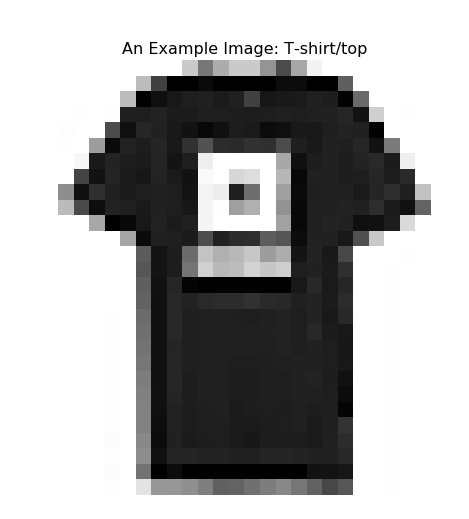

In [13]:
def show(idx, title):
  plt.figure(figsize=(8, 8))
  plt.imshow(test_images[idx].reshape(28,28), cmap='Greys')
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

In [14]:
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:4].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


In [16]:
# Status of the model
requests.get(STATUS_URL).json()

{'model_version_status': [{'version': '1',
   'state': 'AVAILABLE',
   'status': {'error_code': 'OK', 'error_message': ''}}]}

In [17]:
# Metadata
requests.get(METADATA_URL).json()

{'model_spec': {'name': 'fashion_model', 'signature_name': '', 'version': '1'},
 'metadata': {'signature_def': {'signature_def': {'serving_default': {'inputs': {'input_image': {'dtype': 'DT_FLOAT',
       'tensor_shape': {'dim': [{'size': '-1', 'name': ''},
         {'size': '28', 'name': ''},
         {'size': '28', 'name': ''},
         {'size': '1', 'name': ''}],
        'unknown_rank': False},
       'name': 'Conv1_input:0'}},
     'outputs': {'Softmax/Softmax:0': {'dtype': 'DT_FLOAT',
       'tensor_shape': {'dim': [{'size': '-1', 'name': ''},
         {'size': '10', 'name': ''}],
        'unknown_rank': False},
       'name': 'Softmax/Softmax:0'}},
     'method_name': 'tensorflow/serving/predict'}}}}}

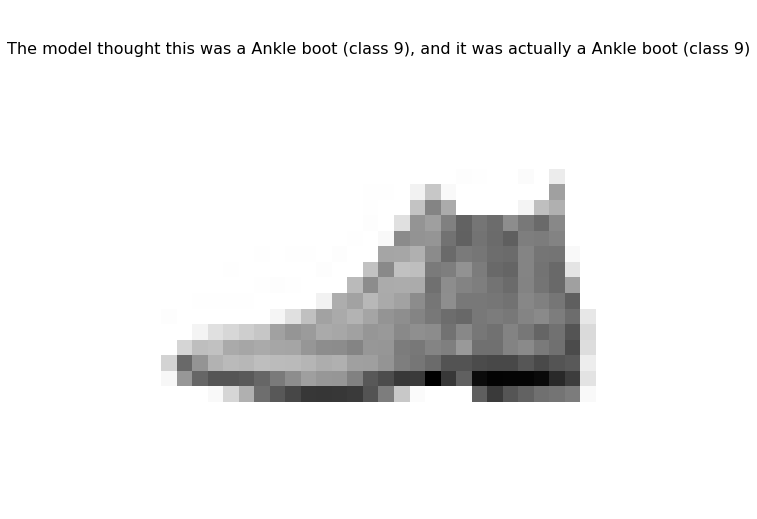

In [18]:
json_response = requests.post(PREDICTION_URL, data=data, headers=HEADERS)
predictions = json.loads(json_response.text)['predictions']

show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], test_labels[0], class_names[test_labels[0]], test_labels[0]))

In [19]:
def multiple_show(items, titles):
  f, axarr = plt.subplots(2,2, figsize=(16, 12))
  axarr[0,0].imshow(test_images[0].reshape(28,28), cmap='Greys')
  axarr[0,0].set_title('\n\n{}'.format(titles[0]))
  axarr[0,1].imshow(test_images[1].reshape(28,28), cmap='Greys')
  axarr[0,1].set_title('\n\n{}'.format(titles[1]))
  axarr[1,0].imshow(test_images[2].reshape(28,28), cmap='Greys')
  axarr[1,0].set_title('\n\n{}'.format(titles[2]))
  axarr[1,1].imshow(test_images[3].reshape(28,28), cmap='Greys')
  axarr[1,1].set_title('\n\n{}'.format(titles[3]))

In [20]:
json_response = requests.post(FIRST_VERSION_PREDICTION_URL, data=data, headers=HEADERS)
predictions = json.loads(json_response.text)['predictions']
items = []
titles = []
for i in range(0,4):
  items.append(i)
  titles.append('Model={}, Actual={}'.format(
    class_names[np.argmax(predictions[i])], class_names[test_labels[i]]))

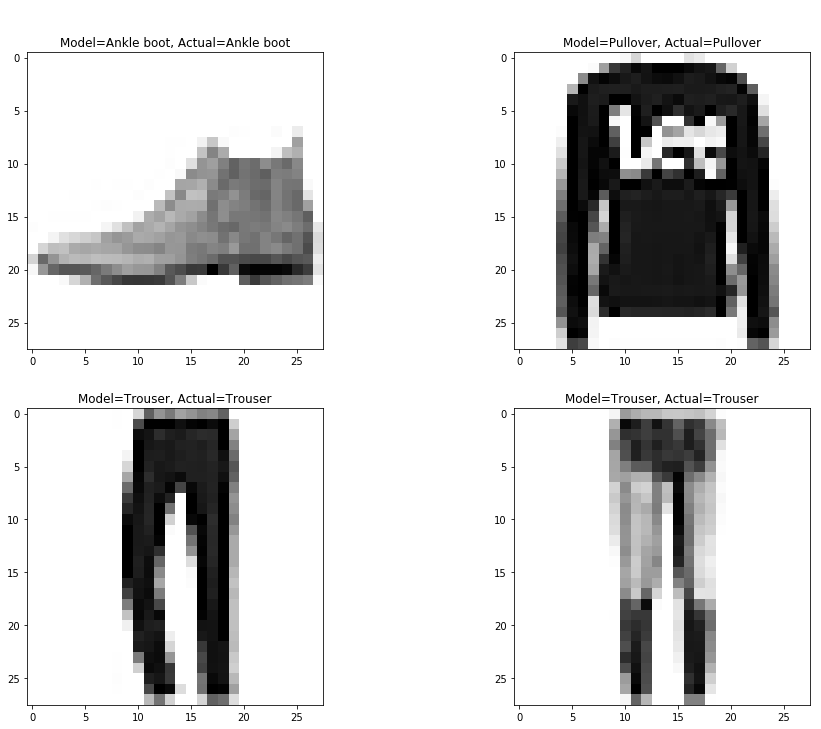

In [21]:
multiple_show(items, titles)